## Setup

In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder,MinMaxScaler,OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import confusion_matrix, classification_report,multilabel_confusion_matrix,make_scorer, f1_score,ConfusionMatrixDisplay
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.base import TransformerMixin, BaseEstimator
from pipelines.src.etl import DataIntoLocalFile, CreateDF
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torchmetrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score


## Loading the Data

In [130]:
# Dentro de CreateDF elimina duplicados, podría separarse en otra función.
def download_save_flare_data():
    data_local = DataIntoLocalFile()
    saved_path = data_local.download_and_extract()
    df_class = CreateDF(saved_path)
    data = df_class.create_dataframe()
    return data

def load_data(filepath):
    data = pd.read_csv(filepath, index_col=False)
    return data

def explore_data(data):
    print(data.head().T)
    print(data.describe())
    print(data.info())
    for col in data.columns:
        if data[col].dtype == object:
            print(f"Value counts for column: {col}")
            print(data[col].apply(lambda x: x if isinstance(x, str) else None).value_counts())

## Adding visualizations 

In [131]:
def plot_histograms(data_df, bins=15, figsize=(15,10)):
    data_df.hist(bins=bins, figsize=figsize)
    plt.show()

In [132]:
def correlation_matrix(data_df):
    plt.figure(figsize=(12, 8))
    sns.heatmap(data_df.corr(), annot=True, fmt=".2f")
    plt.show()

## Preprocessing and Feature Engineering

In [133]:
#target_columns = ['common flares', 'moderate flares', 'severe flares']
def preprocess_data(data_df, columns_to_encode=None):
    if columns_to_encode is None:
        columns_to_encode = ["modified Zurich class", "largest spot size", "spot distribution"]
    pipeline = Pipeline([
        ('encode', make_column_transformer((OrdinalEncoder(), columns_to_encode), remainder='passthrough')),
        #('scale', MinMaxScaler()),  Podemos ir agregando más transformaciones de ser necesario.
       
    ])
    encoded_scaled = pipeline.fit_transform(data_df)
    data_df_processed = pd.DataFrame(encoded_scaled, index=data_df.index, columns=data_df.columns)
    return data_df_processed


## Splitting the Dataset

In [134]:
# Pytorch dataset
class FlareDataset(Dataset):
        def __init__(self, X, y):
            self.X = X
            self.y = y
        
        def __len__(self):
            return len(self.X)
        
        def __getitem__(self, idx):
            return self.X[idx], self.y[0][idx], self.y[1][idx], self.y[2][idx]

def split_data(data_df, test_size=0.2, random_state=42):
    target_output = lambda data: [np.array(data.pop('common flares')),
                                  np.array(data.pop('moderate flares')), 
                                  np.array(data.pop('severe flares'))]
    
    X_train, X_test = train_test_split(data_df, test_size=test_size, random_state=random_state)
    
    y_train = target_output(X_train)
    y_test = target_output(X_test)
    
    # PyTorch tensors
    X_train = torch.tensor(X_train.values, dtype=torch.float32)
    X_test = torch.tensor(X_test.values, dtype=torch.float32)
    y_train = [torch.tensor(target, dtype=torch.float32).unsqueeze(1) for target in y_train]
    y_test = [torch.tensor(target, dtype=torch.float32).unsqueeze(1) for target in y_test]

    print("X_train shape:", X_train.shape)
    print("X_test shape:", X_test.shape)
    print("y_train shape:", [target.shape for target in y_train])
    print("y_test shape:", [target.shape for target in y_test])
    
    return X_train, X_test, y_train, y_test
    
def create_dataloaders(X_train, y_train, X_test, y_test, batch_size=32):
    
    train_dataset = FlareDataset(X_train, y_train)
    test_dataset = FlareDataset(X_test, y_test)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader



## Training the Model


### Training LogisticRegression Model


In [136]:
def train_logistic_regression_model(X_train, y_train):
    # Create LogisticRegression models
    model_lr_common = LogisticRegression(max_iter=1000)
    model_lr_moderate = LogisticRegression(max_iter=1000)
    model_lr_severe = LogisticRegression(max_iter=1000)

    # Fit the models
    model_lr_common.fit(X_train, y_train['common flares'])
    model_lr_moderate.fit(X_train, y_train['moderate flares'])
    model_lr_severe.fit(X_train, y_train['severe flares'])

    # Return all trained models
    return model_lr_common, model_lr_moderate, model_lr_severe

## Training Multi-Output Neural Network


In [137]:
#2 capas Lineales 
#Puede expandirse de manera directa capa por capa.
class SimpleMonnFlare3(nn.Module):
    def __init__(self, input_len=10):
        super(SimpleMonnFlare3, self).__init__()
        self.first_dense = nn.Linear(input_len, 64)
        self.second_dense = nn.Linear(64, 32)
        self.y1_output = nn.Linear(32, 1) 
        self.y2_output = nn.Linear(32, 1) 
        self.y3_output = nn.Linear(32, 1) 
        
    def forward(self, x):
        x = torch.relu(self.first_dense(x))
        x = torch.relu(self.second_dense(x))
        y1 = self.y1_output(x)  # common_flares
        y2 = self.y2_output(x)  # moderate_flares
        y3 = self.y3_output(x)  # severe_flares
        return y1, y2, y3

def train_model(model, dataloader, optimizer, criterion, rmse_metric, epochs=10):
    model.train()
    
    for epoch in range(epochs):
        running_loss = 0.0
        
        for inputs, y1, y2, y3 in dataloader:
            optimizer.zero_grad()
        
            outputs_y1, outputs_y2, outputs_y3 = model(inputs)
            
            loss_y1 = criterion(outputs_y1, y1)
            loss_y2 = criterion(outputs_y2, y2)
            loss_y3 = criterion(outputs_y3, y3)
            
            loss = loss_y1 + loss_y2 + loss_y3
           
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            print(f'Epoch [{epoch+1}/{epochs}] - Average Loss: {running_loss/len(dataloader):.4f}')


def create_model(input_len=9):
    model = SimpleMonnFlare3(input_len=input_len)
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    criterion = nn.MSELoss()
    rmse_metric = torchmetrics.MeanSquaredError(squared=False)
    return model, optimizer, criterion,rmse_metric

## Evaluating the Model

### Evaluating random_forest_classifier Model

In [139]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()


## Evaluating Multi-Output Neural Network

In [140]:

def evaluate_multi_output_metrics(model, test_loader, criterion):
    model.eval()
    
    rmse_y1 = torchmetrics.MeanSquaredError(squared=False)
    rmse_y2 = torchmetrics.MeanSquaredError(squared=False)
    rmse_y3 = torchmetrics.MeanSquaredError(squared=False)
    
    test_loss = 0.0
    
    all_y1_true, all_y2_true, all_y3_true = [], [], []
    all_y1_pred, all_y2_pred, all_y3_pred = [], [], []
    
    with torch.no_grad():
        for inputs, y1, y2, y3 in test_loader:
            
            outputs_y1, outputs_y2, outputs_y3 = model(inputs)
            
            loss_y1 = criterion(outputs_y1, y1)
            loss_y2 = criterion(outputs_y2, y2)
            loss_y3 = criterion(outputs_y3, y3)
            
            loss = loss_y1 + loss_y2 + loss_y3
            test_loss += loss.item()
            
            rmse_y1.update(outputs_y1, y1)
            rmse_y2.update(outputs_y2, y2)
            rmse_y3.update(outputs_y3, y3)
            
            all_y1_true.extend(y1.cpu().numpy())
            all_y2_true.extend(y2.cpu().numpy())
            all_y3_true.extend(y3.cpu().numpy())
            
            all_y1_pred.extend(outputs_y1.cpu().numpy())
            all_y2_pred.extend(outputs_y2.cpu().numpy())
            all_y3_pred.extend(outputs_y3.cpu().numpy())
    
    rmse_y1_value = rmse_y1.compute().item()
    rmse_y2_value = rmse_y2.compute().item()
    rmse_y3_value = rmse_y3.compute().item()
    
    # numpy arrays para MAE y R² 
    all_y1_true = np.array(all_y1_true)
    all_y2_true = np.array(all_y2_true)
    all_y3_true = np.array(all_y3_true)
    
    all_y1_pred = np.array(all_y1_pred)
    all_y2_pred = np.array(all_y2_pred)
    all_y3_pred = np.array(all_y3_pred)
    
    # Calculando MAE and R² for each output
    mae_y1 = mean_absolute_error(all_y1_true, all_y1_pred)
    mae_y2 = mean_absolute_error(all_y2_true, all_y2_pred)
    mae_y3 = mean_absolute_error(all_y3_true, all_y3_pred)
    
    r2_y1 = r2_score(all_y1_true, all_y1_pred)
    r2_y2 = r2_score(all_y2_true, all_y2_pred)
    r2_y3 = r2_score(all_y3_true, all_y3_pred)
    
    print(f'Test Loss: {test_loss/len(test_loader):.4f}')
    
    print(f'RMSE y1 (common flares): {rmse_y1_value:.4f}, MAE y1: {mae_y1:.4f}, R² y1: {r2_y1:.4f}')
    print(f'RMSE y2 (moderate flares): {rmse_y2_value:.4f}, MAE y2: {mae_y2:.4f}, R² y2: {r2_y2:.4f}')
    print(f'RMSE y3 (severe flares): {rmse_y3_value:.4f}, MAE y3: {mae_y3:.4f}, R² y3: {r2_y3:.4f}')
    results_df = pd.DataFrame({
        'Metric': ['RMSE', 'MAE', 'R²'],
        'Common Flares (y1)': [rmse_y1_value, mae_y1, r2_y1],
        'Moderate Flares (y2)': [rmse_y2_value, mae_y2, r2_y2],
        'Severe Flares (y3)': [rmse_y3_value, mae_y3, r2_y3]
    })
    
    rmse_y1.reset()
    rmse_y2.reset()
    rmse_y3.reset()

    return results_df



def cross_validate_simple(X_train, y_train, X_test, y_test, k=5, epochs=10, batch_size=50):
    
    results_list = []
    train_dataset = FlareDataset(X_train, y_train)
    test_dataset = FlareDataset(X_test, y_test)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True) 
    
    for run in range(k): 
        print(f"Run {run+1}")
        
        model, optimizer, criterion, rmse_metric = create_model(input_len=train_dataset[0][0].shape[0])  
        
        train_model(model, train_loader, optimizer, criterion, rmse_metric, epochs=epochs)
        
        test_results_df = evaluate_multi_output_metrics(model, test_loader, criterion)
        
        results_list.append(test_results_df)
   
    all_results_df = pd.concat(results_list, keys=[f"Fold {i+1}" for i in range(k)])
      
    
    mean_results_df = all_results_df.drop(columns='Metric').groupby(level=1).mean()  
    metric_names = ['mean RMSE', 'mean MAE', 'mean R²']
    mean_results_df.index = metric_names
    return all_results_df, mean_results_df
    

## Improving the Model

### Improving random_forest_classifier Model

In [141]:
def cross_validate_random_forest_classifier_model(model_rf, X, y,flare_types,cv=5):
    # Define the scoring method
    scoring = make_scorer(f1_score, average='macro', zero_division=0)

    for flare_type in flare_types:
        # Perform cross-validation
        scores = cross_val_score(model_rf, X, y[flare_type], cv=cv, scoring=scoring)
        
        print(f"F1 scores for {flare_type.capitalize()}:", scores)
        print(f"Mean F1 score for {flare_type.capitalize()}:", scores.mean())


### Improving LogisticRegression Model

In [142]:
def cross_validate_logistic_regression_model(models, X, y,flare_types):
    for model, flare_type in zip(models, flare_types):
        scores = cross_val_score(model, X, y[flare_type], cv=5)
        print(f"Cross-validation scores for {flare_type.capitalize()}:", scores)

## Implementing Main Function 

In [143]:
# Main function for running the pipeline
def main(filepath):
    #De manera opcional se pude correr también esta función desde aquí si no se tiene como iniciar de manera local.
    #download_save_flare_data() 
    data = load_data(filepath)
    explore_data(data)
    
    process_data = preprocess_data(data)
    plot_histograms(process_data)
    correlation_matrix(process_data)
    #X_train, X_test, y_train, y_test = split_data(process_data)
    X_train, X_test, y_train, y_test = split_data(process_data)
    # Crea objeto DataLoader Y es lo que usara el modelo para cargar los datos del split.
    train_loader, test_loader = create_dataloaders(X_train, y_train, X_test, y_test)

    model, optimizer, criterion,rmse_metric = create_model(input_len=X_train.shape[1])

    train_model(model, train_loader, optimizer, criterion, rmse_metric, epochs=10)
    #Modelo se puede guardar en este punto 
    
    metrics = evaluate_multi_output_metrics(model,test_loader,criterion)
    all_results_df, mean_results_df = cross_validate_simple(X_train, y_train, X_test, y_test,k=5,epochs=10,batch_size=50)
    print(metrics)
    print(all_results_df)
    print(mean_results_df)
    

                                 0  1  2  3  4
modified Zurich class            H  D  C  H  H
largest spot size                A  R  S  R  S
spot distribution                X  O  O  X  X
activity                         1  1  1  1  1
evolution                        3  3  3  2  1
previous 24 hour flare activity  1  1  1  1  1
historically-complex             1  1  1  1  1
became complex on this pass      1  2  2  1  2
area                             1  1  1  1  1
common flares                    0  0  0  0  0
moderate flares                  0  0  0  0  0
severe flares                    0  0  0  0  0
         activity   evolution  previous 24 hour flare activity  \
count  365.000000  365.000000                       365.000000   
mean     1.361644    2.378082                         1.164384   
std      0.481136    0.650073                         0.519237   
min      1.000000    1.000000                         1.000000   
25%      1.000000    2.000000                         1.000

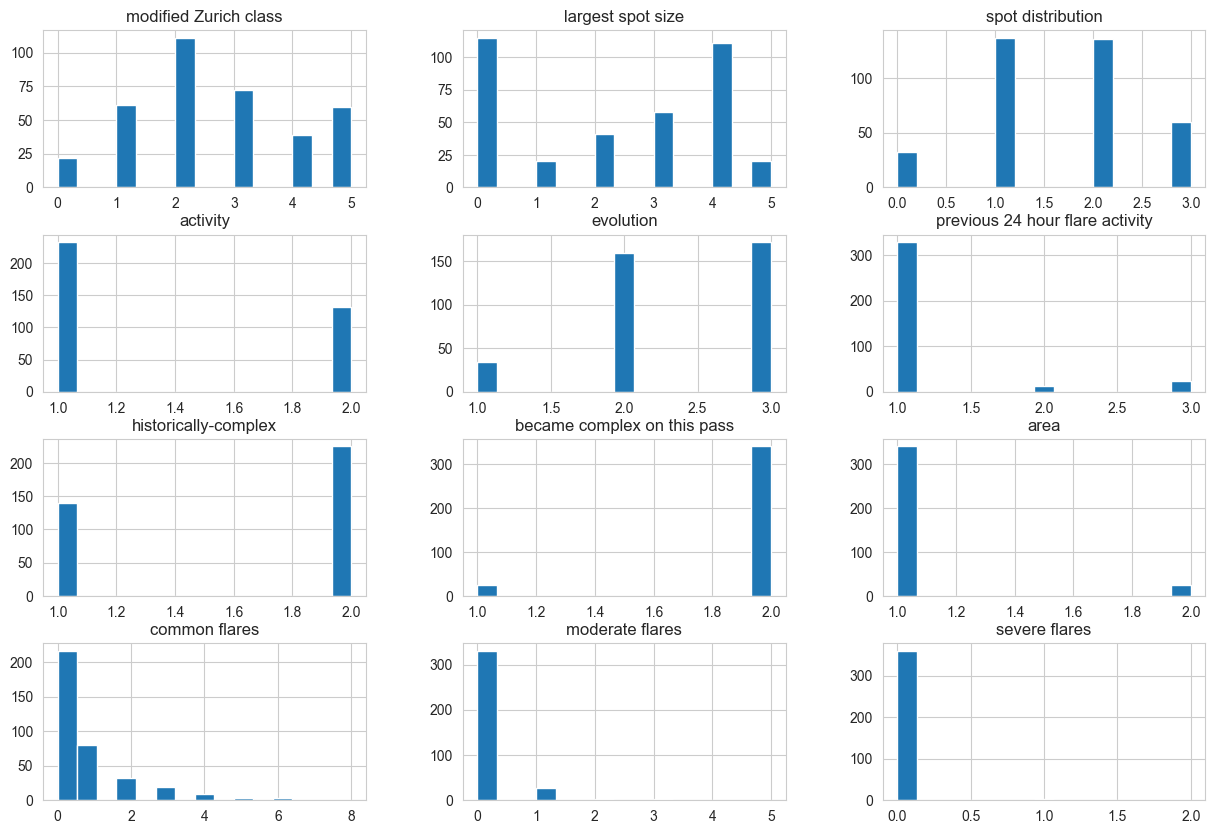

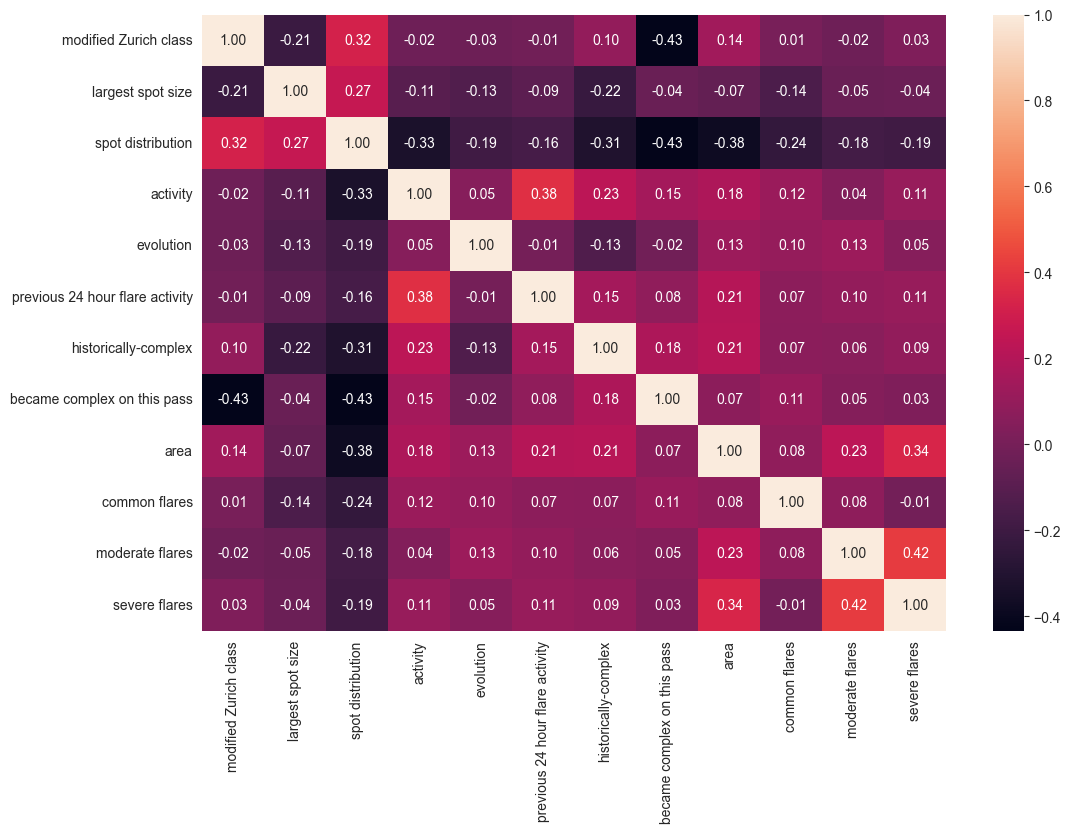

X_train shape: torch.Size([292, 9])
X_test shape: torch.Size([73, 9])
y_train shape: [torch.Size([292, 1]), torch.Size([292, 1]), torch.Size([292, 1])]
y_test shape: [torch.Size([73, 1]), torch.Size([73, 1]), torch.Size([73, 1])]
Epoch [1/10] - Average Loss: 0.4489
Epoch [1/10] - Average Loss: 0.8026
Epoch [1/10] - Average Loss: 1.0444
Epoch [1/10] - Average Loss: 1.1977
Epoch [1/10] - Average Loss: 1.6198
Epoch [1/10] - Average Loss: 1.8352
Epoch [1/10] - Average Loss: 1.9213
Epoch [1/10] - Average Loss: 2.0240
Epoch [1/10] - Average Loss: 2.1617
Epoch [1/10] - Average Loss: 2.1904
Epoch [2/10] - Average Loss: 0.2175
Epoch [2/10] - Average Loss: 0.6287
Epoch [2/10] - Average Loss: 0.8204
Epoch [2/10] - Average Loss: 0.8912
Epoch [2/10] - Average Loss: 1.0653
Epoch [2/10] - Average Loss: 1.3778
Epoch [2/10] - Average Loss: 1.6213
Epoch [2/10] - Average Loss: 1.7364
Epoch [2/10] - Average Loss: 1.8395
Epoch [2/10] - Average Loss: 1.8883
Epoch [3/10] - Average Loss: 0.2883
Epoch [3/10] -

In [144]:
main(filepath=r'/Users/lsfu/Desktop/MNA/Operaciones/TC5044.10_Equipo18/data/raw/flare_data2_df.csv')